In [26]:
from urllib.parse import urlparse, parse_qs, unquote

# Your list of URLs
urls = [
    "https://everynoise.com/everyplace.cgi?root=Igoumenitsa%20GR&scope=all",
    "https://everynoise.com/everyplace.cgi?root=Ierapetra%20GR&scope=all",
    "https://everynoise.com/everyplace.cgi?root=Bani%20Mazar%20EG&scope=all",
    "https://everynoise.com/everyplace.cgi?root=Piliyandala%20LK&scope=all",
    "https://everynoise.com/everyplace.cgi?root=Al%20Khankah%20EG&scope=all"
]

# Process each URL
for url in urls:
    # Parse the URL and extract the query parameters
    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    
    # Check if the 'root' parameter exists
    if 'root' in query_params:
        # Get the first value for 'root' and decode it (e.g., "Igoumenitsa GR")
        root_value = unquote(query_params['root'][0])
        # Split on the last space to separate the city name from the country code
        if ' ' in root_value:
            city, country_code = root_value.rsplit(' ', 1)
            print(f"City: {city}, Country Code: {country_code}")
        else:
            # If the format isn't as expected, indicate an error
            print(f"Unexpected format for {root_value}")
    else:
        print("No 'root' parameter found.")


City: Igoumenitsa, Country Code: GR
City: Ierapetra, Country Code: GR
City: Bani Mazar, Country Code: EG
City: Piliyandala, Country Code: LK
City: Al Khankah, Country Code: EG


In [51]:
import psycopg2
import pandas as pd

try:
    conn = psycopg2.connect(dbname="postgres", user="postgres", password="postgres")
    cur = conn.cursor()
except Exception as e:
    print(f"Database connection failed: {e}")

def fetch_all():
    try:
        cur.execute("""SELECT city_name, region_code, playlist_id, lat, lon, population 
                       FROM cities
                       WHERE city_name IS NOT NULL
                            AND lat IS NOT NULL
                            AND lon IS NOT NULL
                            AND active = TRUE""")
        rows = cur.fetchall()
        # create pandas DataFrame from the rows
        df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])
    except Exception as e:
        print(f"Error fetching data: {e}")

    return df

In [52]:
df = fetch_all()
print(len(df.index))

df.head()

1079


,city_name,region_code,playlist_id,lat,lon,population
0,Presidencia Roque Sáenz Peña,AR,0KvREH6OVZoGbzJrqtxEzG,-26.790909,-60.441039,NaN
1,Resistencia,AR,4miEcWDZC6XjbQoQUMLSji,-27.460000,-58.990000,387158.0
2,Adelaide,AU,7367p7kJaMGmPkG4vai2UQ,-34.935000,138.600000,1295714.0
3,Posadas,AR,6m9a8uxLnKEI6IXnRcsGOf,-27.357800,-55.885100,357119.0
4,Chapecó,BR,1WpSfgBAtLKoHmLkVuorw8,-27.100000,-52.640000,224013.0


In [53]:
df2 = pd.read_csv("../data/cities.csv")
df3 = pd.read_csv("../data/region_names_and_codes.csv")

In [54]:
# remove duplicates from cities.csv
df2 = df2.drop_duplicates(subset=['city_name', 'country'], keep='first')
df2.head()

,city_id,city_name,country,lat,lon,population
0,1642,Puerto Williams,Chile,-54.93330,-67.6167,2500.0
1,333,Ushuaia,Argentina,-54.79000,-68.3100,58028.0
2,380235,Tolhuin,Argentina,-54.51083,-67.1955,3000.0
3,332,Rio Grande,Argentina,-53.79140,-67.6990,31095.0
4,1662,Punta Arenas,Chile,-53.16500,-70.9400,123403.0


In [55]:
df3["code"] = df3["code"].str.upper()
df3.head()

,name,code
0,Global,WW
1,Argentina,AR
2,Australia,AU
3,Austria,AT
4,Belarus,BY


In [56]:
df4 = df.merge(df3, how="left", left_on="region_code", right_on="code")
df4.drop(columns=["code"], inplace=True)
df4.rename(columns={"name": "country_name"}, inplace=True)
df4.head()

,city_name,region_code,playlist_id,lat,lon,population,country_name
0,Presidencia Roque Sáenz Peña,AR,0KvREH6OVZoGbzJrqtxEzG,-26.790909,-60.441039,NaN,Argentina
1,Resistencia,AR,4miEcWDZC6XjbQoQUMLSji,-27.460000,-58.990000,387158.0,Argentina
2,Adelaide,AU,7367p7kJaMGmPkG4vai2UQ,-34.935000,138.600000,1295714.0,Australia
3,Posadas,AR,6m9a8uxLnKEI6IXnRcsGOf,-27.357800,-55.885100,357119.0,Argentina
4,Chapecó,BR,1WpSfgBAtLKoHmLkVuorw8,-27.100000,-52.640000,224013.0,Brazil


In [57]:
# check the dataframe
print(f"length of df4: {len(df4.index)}")
print(f"number of nans after merge: {df4['country_name'].isna().sum()}")

length of df4: 1079
number of nans after merge: 134


In [58]:
df4 = df4.drop(columns=["lat", "lon"])
df5 = df4.merge(df2, how="left", left_on=["city_name", "country_name"], right_on=["city_name", "country"])

In [59]:
# check the dataframe after merge
print(f"length of df5: {len(df5.index)}")
print(f"number of nans after merge: {df5['lat'].isna().sum()}")

length of df5: 1079
number of nans after merge: 349


In [60]:
df

,city_name,region_code,playlist_id,lat,lon,population
0,Presidencia Roque Sáenz Peña,AR,0KvREH6OVZoGbzJrqtxEzG,-26.790909,-60.441039,NaN
1,Resistencia,AR,4miEcWDZC6XjbQoQUMLSji,-27.460000,-58.990000,387158.0
2,Adelaide,AU,7367p7kJaMGmPkG4vai2UQ,-34.935000,138.600000,1295714.0
3,Posadas,AR,6m9a8uxLnKEI6IXnRcsGOf,-27.357800,-55.885100,357119.0
4,Chapecó,BR,1WpSfgBAtLKoHmLkVuorw8,-27.100000,-52.640000,224013.0
...,...,...,...,...,...,...
1074,Copiapó,CL,5xEDQSHaFDskFlSaf4djb4,-27.366468,-70.332275,NaN
1075,San Miguel de Tucumán,AR,5cNt5a1zzvU1YE8E5YGlA6,-26.816000,-65.216600,830000.0
1076,Curitiba,BR,0CLUE974345Z72AtNr6rgx,-25.420000,-49.320000,3084000.0
1077,Itanhaem,BR,6yQNYtOBw8z5tHuO8sH3io,-24.180000,-46.800000,90385.0


In [ ]:
# Define lat_range and lon_range if not already defined
lat_range = 2
lon_range = 2

# Add columns for grouping by 2° latitude and longitude
df['lat_bin'] = (df['lat'] // lat_range).astype(int)
df['lon_bin'] = (df['lon'] // lon_range).astype(int)

# Define a function to select the city with the largest population or a random one
def select_city(group):
    if group['population'].notna().any():
        return group.loc[group['population'].idxmax()]
    else:
        # return a random city with the least ampount of white spaces in the name
        # the idea here is to prevent suburbs from being selected
        group = group[group['city_name'].str.count(' ') == group['city_name'].str.count(' ').min()]
        return group.sample(n=1).iloc[0]

# Group by lat_bin and lon_bin and apply the selection function
filtered_df = df.groupby(['lat_bin', 'lon_bin']).apply(select_city).reset_index(drop=True)

# Drop the temporary lat_bin and lon_bin columns
filtered_df.drop(columns=['lat_bin', 'lon_bin'], inplace=True)

len(filtered_df.index)


C:\Users\miche\AppData\Local\Temp\ipykernel_15404\2995035083.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby(['lat_bin', 'lon_bin']).apply(select_city).reset_index(drop=True)


1071

In [68]:
# using the connection to the database above alter the active column in the cities table 1 where the city is in the filtered_df and 0 where it is not
def update_active_column(df, conn):
    try:
        cur = conn.cursor()
        # Set all rows to inactive (active = 0)
        cur.execute("UPDATE cities SET active = '0'")
        
        # Update rows that are in the filtered_df to active (active = 1)
        for index, row in df.iterrows():
            city_name = row['city_name']
            region_code = row['region_code']
            cur.execute(
                "UPDATE cities SET active = '1' WHERE city_name = %s AND region_code = %s",
                (city_name, region_code)
            )
        
        conn.commit()
    except Exception as e:
        conn.rollback()
        print(f"Error updating active column: {e}")
    finally:
        cur.close()

# Call the function to update the active column
update_active_column(filtered_df, conn)

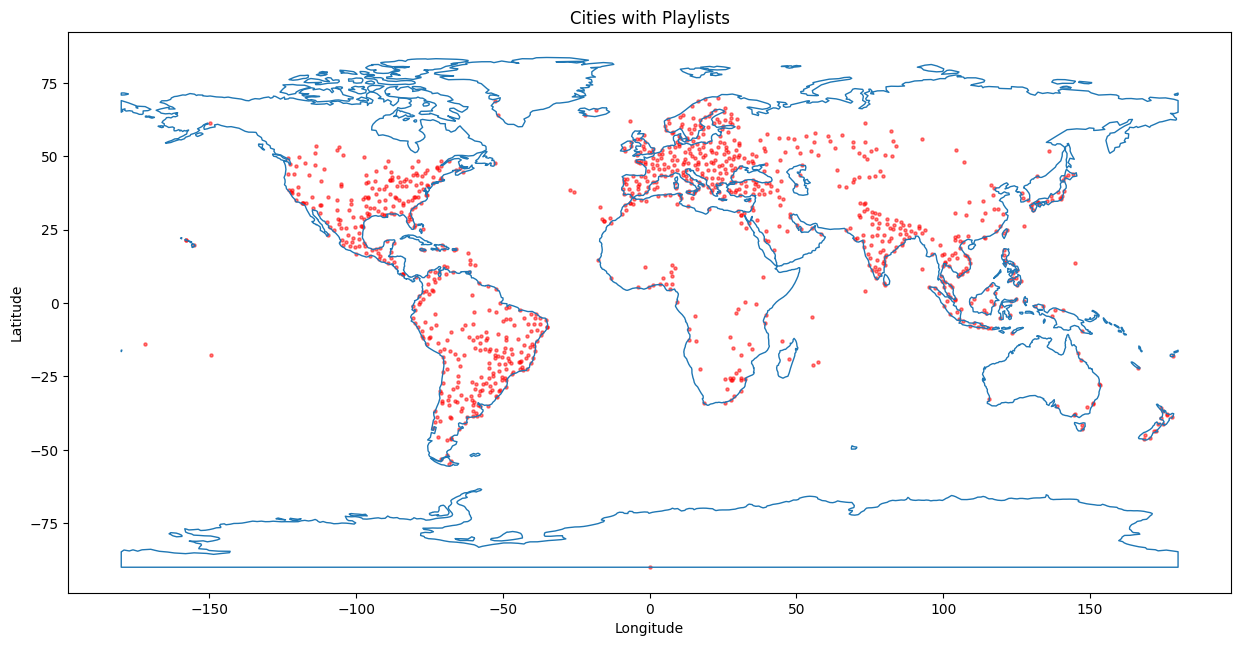

In [69]:
# visualize all points with coordinates on a world map
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets

df1 = filtered_df.copy()

# create a GeoDataFrame from the DataFrame
geometry = [Point(xy) for xy in zip(df1['lon'], df1['lat'])]
gdf = gpd.GeoDataFrame(df1, geometry=geometry)

# load world map
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))
# plot the points on the world map
fig, ax = plt.subplots(figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)
plt.title('Cities with Playlists')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [70]:
# find the cities with the lowest population
df1[df1['population'].notna()].sort_values(by='population', ascending=True).head(20)

,city_name,region_code,playlist_id,lat,lon,population
537,San Juan de los Lagos,MX,46dUGZt12bvKBBDLgYxz1A,28.138360,-105.467960,7.0
425,El Pueblito,MX,1n9TPfftoDuqtpxZGNL5nv,18.997730,-100.467890,8.0
423,Ameca,MX,7s4ppVR4aZ0SDn9Aq6ex7q,19.888610,-104.493890,25.0
403,Solidaridad,MX,10iTjgEM3AcSpfRtVFwyLS,17.106940,-96.737780,115.0
0,South Pole,AN,0io8mdPGCHy3ut1ToqBGUf,-90.000000,0.000000,187.0
196,Huánuco,PE,7DVjn62uOhqxbadaOhS3GH,-11.563450,-74.885560,442.0
491,General Escobedo,MX,3FRPPr57vWwGtsY7EGKmt4,25.514460,-105.242300,779.0
858,Montreal,CA,0L6YIDujF6k8Ojvnk5wqWn,46.428000,-90.246010,783.0
224,Tarapoto,PE,1sRI4GnDQVySH3VUOM2Wne,-6.510000,-76.480000,936.0
405,Puebla,MX,4G6hM89eQ1tr1X9vYu10aq,16.915830,-92.503890,1245.0
